# Import libraries

In [4]:
from tensorflow.keras import layers, initializers, callbacks, models, optimizers, activations, backend, losses, metrics, regularizers
from tensorflow.keras.wrappers import SKLearnRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
import math

# Create dataset

In [ ]:
X, y = make_regression(n_samples=100000,
                                     n_features=10,
                                     n_informative=4,
                                     noise=0.1,
                                     random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Exponential Learning Rate Callback

In [ ]:
class ExponentialLearningRate(callbacks.Callback):

    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        # get current LR
        lr = backend.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs.get("loss"))
        # compute new LR
        new_lr = lr * self.factor
        # set new LR (works with modern Keras)
        self.model.optimizer.learning_rate.assign(new_lr)

# Set up logging and callbacks

In [ ]:
run_index = 1  # increment this at every run
run_logdir = os.path.join(os.curdir, "regressor_logs", "run_{:03d}".format(run_index))

tensorboard_cb = callbacks.TensorBoard(run_logdir)

In [ ]:
early_stop = callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

expon_lr = ExponentialLearningRate(factor=1.005)

# Build and train model (DNN Regressor)

In [ ]:
def build_model(X, y, n_hidden=1, n_neurons=30, learning_rate=0.0001):
    input_shape = X.shape[1:]
    model = models.Sequential()
    model.add(layers.InputLayer(shape=input_shape))
    for _ in range(n_hidden):
        model.add(layers.Dense(units=n_neurons,
                               activation=activations.relu,
                               kernel_initializer=initializers.HeNormal()))
    model.add(layers.Dense(units=1))
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=losses.mse,
                  optimizer=optimizer,
                  metrics=[metrics.mse, metrics.mae, metrics.mape, metrics.huber])
    return model

In [ ]:
estimator = SKLearnRegressor(model=build_model)

In [ ]:
history = estimator.fit(X_train,
                        y_train,
                        epochs=1,
                        validation_data=(X_valid, y_valid),
                        callbacks=[
                            early_stop,
                            expon_lr,

                        ],
                        verbose=2)

# Analyze LR-finder results

In [ ]:
idx = np.argmin(expon_lr.losses)
best_lr_sweep = expon_lr.rates[idx] / 10
print("LR-finder min loss lr:", best_lr_sweep)
print("loss at that lr:", expon_lr.losses[idx])
print("min/max lr in sweep:", min(expon_lr.rates), max(expon_lr.rates))

smoothed = gaussian_filter1d(expon_lr.losses, sigma=2)

plt.plot(expon_lr.rates, expon_lr.losses, alpha=0.3, label='batch loss')
plt.plot(expon_lr.rates, smoothed, label='smoothed loss')
plt.xscale('log')
plt.scatter([best_lr_sweep], [expon_lr.losses[idx]], color='red', label=f'best lr {best_lr_sweep:.2e}')
plt.legend()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

# Hyperparameter tuning with Randomized Search CV on DNN Regressor

In [ ]:
param_grid = {
    "model_kwargs": [
        {"n_hidden": h, "n_neurons": n, "learning_rate": lr}
        for h in [1, 2, 3, 4]
        for n in [16, 32, 64, 128]
        for lr in [0.03, 0.003, 0.0003]
    ]
}

search = RandomizedSearchCV(estimator,
                            param_distributions=param_grid,
                            n_iter=10,
                            cv=3,
                            scoring=""
                                    "",
                            verbose=2)

search.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose=0)

In [ ]:
best_model = search.best_estimator_
best_params = search.best_params_
print("Best parameters:", best_params)

In [ ]:
best_params = {'model_kwargs': {'n_hidden': 2, 'n_neurons': 128, 'learning_rate': 0.044}}

In [ ]:
y_pred= best_model.predict(X_valid)
mse = ((y_valid - y_pred.flatten()) ** 2).mean()
print("Best model MSE on validation set:", mse)

# Create a final model with the best hyperparameters and train it

In [ ]:
estimator = SKLearnRegressor(model=build_model, **best_params)

In [ ]:
history = estimator.fit(X_train,
                        y_train,
                        epochs=100,
                        validation_data=(X_valid, y_valid),
                        callbacks=[
                            early_stop,
                            tensorboard_cb
                        ],
                        verbose=2)

 # CIFAR10 Image Classification with DNN Classifier

1. DNN with 20 hidden layers, each with 100 neurons, ReLU activation, He initialization.
2. Use Nadam and EarlyStopping with patience of 5 epochs.
3. Add BatchNormalization after each hidden layer. ( compare results with and without BatchNorm)
4. Change to SELU + Lecun Normal initialization. ( compare results with and without BatchNorm)
5. Add AlfaDropout with rate 0.1 after each hidden layer. ( compare results with and without BatchNorm)
6. Train model with LR found by LR-finder.

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [3]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)

X_train_scaled = (X_train - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [ ]:
X_train[:1].shape

#### 1. DNN with 20 hidden layers, each with 100 neurons, ReLU activation, He initialization.

In [ ]:
model = models.Sequential()

model.add(layers.InputLayer(shape=(32, 32, 3)))
model.add(layers.Flatten())

for i in range(20):
    model.add(layers.Dense(units=100,
                           activation=activations.elu,
                           kernel_initializer=initializers.he_normal))

model.add(layers.Dense(units=10, activation=activations.softmax))

#### 2. Use Nadam and EarlyStopping with patience of 5 epochs.

In [ ]:
model.compile(loss=losses.sparse_categorical_crossentropy,
              optimizer=optimizers.Nadam(learning_rate=5e-5),
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
model_checkpoint_cb = callbacks.ModelCheckpoint(
    "cifar10_dnn_model.keras",
    save_best_only=True
)

run_idx = 3
log_dir = os.path.join(os.curdir, "cifar10_dnn_logs", "run_{:03d}".format(run_idx))

tensor_board_cb = callbacks.TensorBoard(
    log_dir=log_dir
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./cifar10_dnn_logs --port=6006

In [ ]:
model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[
    early_stopping_cb,
    model_checkpoint_cb,
    tensor_board_cb
]
)
# Epoch 20/50 1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5684 - loss: 1.2049 - val_accuracy: 0.4993 - val_loss: 1.4410

In [ ]:
model = models.load_model("cifar10_dnn_model.keras")
model.evaluate(X_valid, y_valid)

In [3]:
backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential()
model.add(layers.InputLayer(shape=(32,32,3)))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())

for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer=initializers.he_normal))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.elu))

model.add(layers.Dense(10, activation=activations.softmax))

model.compile(loss=losses.sparse_categorical_crossentropy,
              optimizer=optimizers.Nadam(learning_rate=5e-4),
              metrics=['accuracy'])

early_stopping_cb = callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
model_checkpoint_cb = callbacks.ModelCheckpoint(
    "cifar10_dnn_model.keras",
    save_best_only=True
)

run_idx = 4
log_dir = os.path.join(os.curdir, "cifar10_dnn_logs", "run_{:03d}".format(run_idx))

tensor_board_cb = callbacks.TensorBoard(
    log_dir=log_dir
)

model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
    early_stopping_cb,
    model_checkpoint_cb,
    tensor_board_cb
]
)
# Epoch 10/100 1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.5768 - loss: 1.2098 - val_accuracy: 0.4542 - val_loss: 1.6075


Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.3463 - loss: 1.8284 - val_accuracy: 0.4190 - val_loss: 1.6300
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.4126 - loss: 1.6533 - val_accuracy: 0.4361 - val_loss: 1.5754
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.4450 - loss: 1.5708 - val_accuracy: 0.4546 - val_loss: 1.5437
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.4689 - loss: 1.5060 - val_accuracy: 0.4648 - val_loss: 1.5254
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.4908 - loss: 1.4461 - val_accuracy: 0.4639 - val_loss: 1.5179
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.5118 - loss: 1.3905 - val_accuracy: 0.4587 - val_loss: 1.5351
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5302 - loss: 1.3413 - val_accuracy: 0.4609 - val_loss: 1.5470
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy:

#### Change to SELU + Lecun Normal initialization. ( compare results with and without BatchNorm)

In [7]:
backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential()
model.add(layers.InputLayer(shape=(32,32,3)))
model.add(layers.Flatten())

for _ in range(20):
    model.add(layers.Dense(100,
                                 kernel_initializer=initializers.lecun_normal,
                                 activation=activations.selu))

model.add(layers.Dense(10, activation=activations.softmax))

model.compile(loss=losses.sparse_categorical_crossentropy,
              optimizer=optimizers.Nadam(learning_rate=7e-4),
              metrics=['accuracy'])

early_stopping_cb = callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)
model_checkpoint_cb = callbacks.ModelCheckpoint(
    "cifar10_dnn_model.keras",
    save_best_only=True
)

run_idx = 6
log_dir = os.path.join(os.curdir, "cifar10_dnn_logs", "run_{:03d}".format(run_idx))

tensor_board_cb = callbacks.TensorBoard(
    log_dir=log_dir
)



model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_test_scaled, y_test),
          callbacks=[
    early_stopping_cb,
    model_checkpoint_cb,
    tensor_board_cb
])
# Epoch 31/100 1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6309 - loss: 1.0734 - val_accuracy: 0.4968 - val_loss: 1.5833

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.3151 - loss: 1.9074 - val_accuracy: 0.3757 - val_loss: 1.7227
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.3979 - loss: 1.6941 - val_accuracy: 0.4339 - val_loss: 1.5937
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4307 - loss: 1.6036 - val_accuracy: 0.4506 - val_loss: 1.5781
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4606 - loss: 1.5321 - val_accuracy: 0.4550 - val_loss: 1.5408
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4794 - loss: 1.4790 - val_accuracy: 0.4609 - val_loss: 1.5449
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4996 - loss: 1.4270 - val_accuracy: 0.4784 - val_loss: 1.5082
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5145 - loss: 1.3827 - val_accuracy: 0.4898 - val_loss: 1.5040
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 

#### Add AlfaDropout with rate 0.1 after each hidden layer. ( compare results with and without BatchNorm)

In [8]:
class MCAlphaDropout(layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

mc_model = models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, layers.AlphaDropout) else layer
    for layer in model.layers
])

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)



In [10]:
backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_test_scaled)
accuracy = np.mean(y_pred == y_test[:, 0])
accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


np.float64(0.4879)

#### Train model with LR found by LR-finder

In [11]:
backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential()
model.add(layers.InputLayer(shape=(32,32,3)))
model.add(layers.Flatten())
for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer=initializers.lecun_normal, activation=activations.selu))

model.add(layers.AlphaDropout(rate=0.1))
model.add(layers.Dense(10, activation=activations.softmax))

model.compile(loss=losses.sparse_categorical_crossentropy,
              optimizer=optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

#### 1Cycle scheduling

In [24]:
import math

class ExponentialLearningRate(callbacks.Callback):

    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        # get current LR
        lr = backend.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs.get("loss"))
        # compute new LR
        new_lr = lr * self.factor
        # set new LR (works with modern Keras)
        self.model.optimizer.learning_rate.assign(new_lr)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-5, max_rate=10.0):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)

    lr_var = model.optimizer.learning_rate
    init_lr = float(lr_var.numpy())
    lr_var.assign(min_rate)

    exp_lr = ExponentialLearningRate(factor)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])

    lr_var.assign(init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis((min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2))
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential([
    layers.InputLayer(shape=(32,32,3)),
    layers.Flatten(),
    layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1799 - loss: nan


(np.float64(9.999999747378752e-06),
 np.float64(9.652833938598633),
 np.float64(2.4113738536834717),
 np.float64(3.6479352201734274))

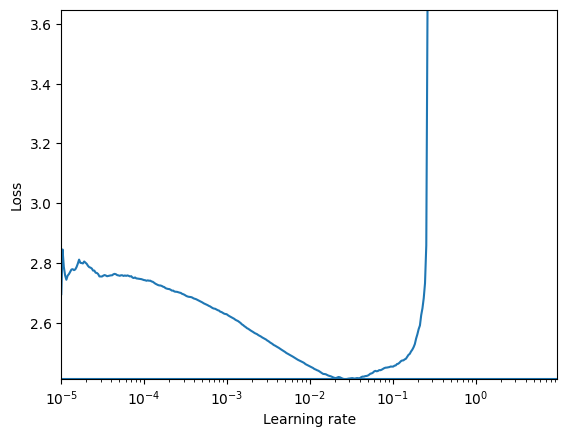

In [26]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis((min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4))

In [11]:
from __future__ import annotations

from typing import Optional


class OneCycleScheduler(callbacks.Callback):
    """
    Keras callback implementing the 1‑cycle learning rate policy.

    The schedule is split into three phases over a fixed number of iterations
    (batches):
    1. Warm‑up: learning rate increases linearly from `start_rate` to `max_rate`.
    2. Cool‑down: learning rate decreases linearly from `max_rate` back to
       `start_rate`.
    3. Final annealing: learning rate decreases linearly from `start_rate` to
       `last_rate` during the last `last_iterations` steps.

    Parameters
    ----------
    iterations : int
        Total number of training iterations (batches) over which the 1‑cycle
        schedule is applied. Typically:
        `iterations = ceil(num_samples / batch_size) * num_epochs`.
    max_rate : float
        Maximum learning rate reached during the cycle.
    start_rate : Optional[float], default=None
        Initial learning rate. If `None`, it is set to `max_rate / 10`.
    last_iterations : Optional[int], default=None
        Number of iterations in the final annealing phase.
        If `None`, it is set to `iterations // 10 + 1`.
    last_rate : Optional[float], default=None
        Final learning rate at the end of training.
        If `None`, it is set to `start_rate / 1000`.

    Attributes
    ----------
    iterations : int
        Total number of iterations in the schedule.
    max_rate : float
        Maximum learning rate in the schedule.
    start_rate : float
        Starting learning rate.
    last_iterations : int
        Number of iterations used for the final annealing phase.
    half_iteration : int
        Number of iterations in each of the first two phases
        (warm‑up and cool‑down).
    last_rate : float
        Final learning rate value.
    iteration : int
        Counter of how many iterations (batches) have been processed.

    Notes
    -----
    This callback updates `model.optimizer.learning_rate` on each batch.
    It supports both `tf.Variable` learning rates (via `assign`) and plain
    Python/float learning rates (via attribute assignment).
    """

    def __init__(
        self,
        iterations: int,
        max_rate: float,
        start_rate: Optional[float] = None,
        last_iterations: Optional[int] = None,
        last_rate: Optional[float] = None,
    ) -> None:
        super().__init__()
        self.iterations: int = iterations
        self.max_rate: float = max_rate
        self.start_rate: float = start_rate if start_rate is not None else max_rate / 10.0
        self.last_iterations: int = last_iterations if last_iterations is not None else iterations // 10 + 1
        self.half_iteration: int = (iterations - self.last_iterations) // 2
        self.last_rate: float = last_rate if last_rate is not None else self.start_rate / 1000.0
        self.iteration: int = 0

    def _interpolate(self, iter1: int, iter2: int, rate1: float, rate2: float) -> float:
        """
        Linearly interpolate a learning rate between two iterations.

        Parameters
        ----------
        iter1 : int
            Start iteration of the interval.
        iter2 : int
            End iteration of the interval.
        rate1 : float
            Learning rate at `iter1`.
        rate2 : float
            Learning rate at `iter2`.

        Returns
        -------
        float
            Interpolated learning rate for the current `self.iteration`.
        """
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1)) + rate1

    def on_batch_begin(self, batch: int, logs: Optional[dict] = None) -> None:
        """
        Update the optimizer learning rate at the beginning of each batch.

        Parameters
        ----------
        batch : int
            Index of the current batch within the epoch.
        logs : Optional[dict], default=None
            Dictionary of logs; not used but kept for API compatibility.
        """
        if self.iteration < self.half_iteration:
            # Warm‑up phase
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            # Cool‑down phase
            rate = self._interpolate(
                self.half_iteration,
                2 * self.half_iteration,
                self.max_rate,
                self.start_rate,
            )
        else:
            # Final annealing phase
            rate = self._interpolate(
                2 * self.half_iteration,
                self.iterations,
                self.start_rate,
                self.last_rate,
            )

        self.iteration += 1

        lr = self.model.optimizer.learning_rate  # type: ignore[attr-defined]
        if hasattr(lr, "assign"):
            lr.assign(rate)
        else:
            self.model.optimizer.learning_rate = rate  # type: ignore[assignment]


In [13]:
n_epochs = 25
batch_size = 128

onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[onecycle],
                    verbose=2)

# One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size).
# This is several times faster than the fastest model we trained so far.
# Moreover, we improved the model's performance (from 47.6% to 52.0%).
# The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.

Epoch 1/25
391/391 - 7s - 17ms/step - accuracy: 0.8223 - loss: 0.5601 - val_accuracy: 0.5155 - val_loss: 1.5992
Epoch 2/25
391/391 - 6s - 16ms/step - accuracy: 0.8186 - loss: 0.5672 - val_accuracy: 0.5118 - val_loss: 1.6523
Epoch 3/25
391/391 - 6s - 15ms/step - accuracy: 0.8151 - loss: 0.5732 - val_accuracy: 0.5116 - val_loss: 1.7128
Epoch 4/25
391/391 - 7s - 17ms/step - accuracy: 0.8096 - loss: 0.5837 - val_accuracy: 0.5063 - val_loss: 1.7916
Epoch 5/25
391/391 - 9s - 24ms/step - accuracy: 0.7989 - loss: 0.6033 - val_accuracy: 0.4986 - val_loss: 1.8841
Epoch 6/25
391/391 - 8s - 21ms/step - accuracy: 0.7863 - loss: 0.6335 - val_accuracy: 0.4919 - val_loss: 1.9620
Epoch 7/25
391/391 - 8s - 20ms/step - accuracy: 0.7741 - loss: 0.6641 - val_accuracy: 0.4901 - val_loss: 2.0399
Epoch 8/25
391/391 - 6s - 15ms/step - accuracy: 0.7602 - loss: 0.7083 - val_accuracy: 0.4835 - val_loss: 2.0686
Epoch 9/25
391/391 - 6s - 16ms/step - accuracy: 0.7609 - loss: 0.6953 - val_accuracy: 0.4759 - val_loss:

# Review of results

Epoch 25/25 391/391 - 8s - 20ms/step - accuracy: **0.9518** - loss: 0.1856 - val_accuracy: **0.5170** - val_loss: 2.3441

1. Train score is 95.18% but validation score is 51.70% - model is overfitting !
2. We can fix it by adding regularization techniques like Dropout, Data Augmentation, etc.
3. Seems model with BatchNorm is better in terms of accuracy but slower in terms of training time.